# Extended Data Figures for *Luo et al. 2021*

(*A high-resolution HLA reference panel capturing global population diversity enables multi-ethnic fine-mapping in HIV host response*)


**Code for reproducing extended data figures in the manuscript**

For any question please contact the first and corresponding author Yang Luo: yangluo@broadinstitute.org

## loading up libraries and presettings

In [5]:
#Load libraries
suppressPackageStartupMessages({
    library(ggplot2)
    library(reshape2)
    library(reticulate)
    library(repr)
    library(patchwork)
    library(plyr)
    library(scales)
    library(RColorBrewer)
    library(dplyr)
    library(data.table)
    library(ggthemes)
    library(ggsci)
    library(rsvd)
    library(tidyr)
    library(ggrepel)
    library(umap)
    library(gridExtra)
    library(cowplot)
    library(plotrix)
    library(ggpubr)
    library(grid)
    library(corrplot)
    library(stringr)
})

Warning message:
“package ‘ggplot2’ was built under R version 3.6.2”
Warning message:
“package ‘reshape2’ was built under R version 3.6.2”
Warning message:
“package ‘reticulate’ was built under R version 3.6.2”
Warning message:
“package ‘patchwork’ was built under R version 3.6.2”
Warning message:
“package ‘scales’ was built under R version 3.6.2”
Warning message:
“package ‘dplyr’ was built under R version 3.6.2”
Warning message:
“package ‘tidyr’ was built under R version 3.6.2”
Warning message:
“package ‘umap’ was built under R version 3.6.2”
Warning message:
“package ‘cowplot’ was built under R version 3.6.2”
Warning message:
“package ‘plotrix’ was built under R version 3.6.2”
Warning message:
“package ‘ggpubr’ was built under R version 3.6.2”


In [6]:
# set global plotting parameters
theme_set(theme_classic() + theme(text = element_text(size=20, family = "sans")))

options(repr.plot.width = 5, repr.plot.height = 5)

#pop_colors <- c("black", "#E69F00","#56B4E9","#D55E00","#009E73")
pop_colors <- c("#938dd2","#E69F00" ,"#56B4E9","#D55E00","#009E73")

pop_labels <- c("Admixed African","East Asian","European","Latino", "South Asian")

#Calc color palette (discrete)
gene_colors <- c("A"="#004586", "B" = "#ff420e", "C"="#ffd320", 
                 "DQA1" = "#579d1c", "DQB1" = "#7e0021", "DRB1" = "#83caff","DPA1" = "#314004", "DPB1" = "#aecf00"  )


## HIV imputation dosage r2 (Extended Data Figure 2)

In [11]:
r2 <- read.table("../data/r2_summary.txt.gz",h=T,stringsAsFactors = F, comment.char = "#")
hiv <- r2 %>% select(allele,HIV_r2,HIV_freq) %>% na.omit()

In [12]:
# assign resolutions
hiv$num <- unlist(sapply(hiv$allele,function(x) str_count(x, ":")) )                   
hiv$resolution <- NA

hiv$resolution <- ifelse(hiv$num>=2,"G-group",hiv$resolution)
hiv$resolution <- ifelse(hiv$num==1,"two-field",hiv$resolution)
hiv$resolution <- ifelse(hiv$num==0,"one-field",hiv$resolution)


[1] 0.8307284

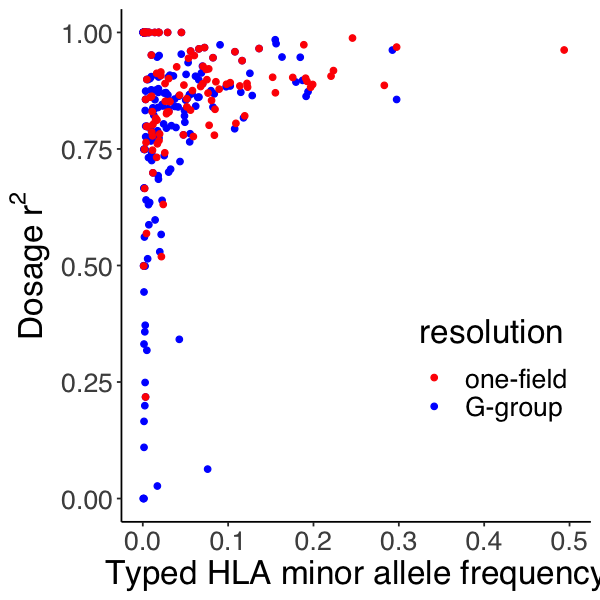

In [20]:
hiv$resolution <- factor(hiv$resolution, levels = c("one-field","G-group"))
mean(hiv[hiv$resolution=="G-group" &hiv$HIV_freq>0.005,]$HIV_r2,na.rm=T)

ggplot(na.omit(hiv),aes(HIV_freq,HIV_r2,col=resolution)) + 
geom_point()  +
xlim(0,0.5) + ylim(0,1) + 
    xlab("Typed HLA minor allele frequency") + ylab(expression("Dosage"~r^2)) +
    scale_color_manual(values=c("red","blue"),
                      labels = c("one-field","G-group")) +
    theme(legend.position=c(0.8,0.3))


ggsave(filename = "../figs/EDF2_dosage_r2.pdf",width=180,height=180,units="mm")


In [25]:
hiv %>% filter(resolution!="G-group" & HIV_r2 <0.5)

allele,HIV_r2,HIV_freq,num,resolution
<chr>,<dbl>,<dbl>,<int>,<fct>
DQA1*06,0.4989496,0.001048218,0,one-field
DPB1*39,0.2178933,0.003232759,0,one-field


## spVL of position 97 in HLA-B (Extended Data Figure 4)

In [16]:
tidyData <- function(pop="eur",haplo = read.table("../data/haplo.1.txt",sep=",",h=F,stringsAsFactors = F )){
  # read in data
  fname <- paste("../data/",pop,".3.phased.gz",sep="")
  x<-read.table(fname,h=F,stringsAsFactors = F)
  sample <- scan(paste("../data/",pop,".header",sep=""),as.character())
  phenoALL <- read.table(paste("../data/",pop,".pheno",sep = ""),h=F,stringsAsFactors = F)
  pheno <- phenoALL %>% filter(V1 %in% sample) %>% filter(V3!=-9)
  plt.df <- NULL
  for (i in c(1:nrow(haplo))){
    geno <- t(x[x[,2] %in% haplo[i,],])
    
    resString <- unlist(strsplit(haplo[i,],"_"))[6]
    #print(resString)
    plt.df <- rbind(plt.df,data.frame(sample=pheno$V1,vl=pheno$V3,res=resString,
                                      present=ifelse(pheno$V1 %in% sample[rowSums(geno == "T") == 1],1,0),
                                      pop=pop)
    )
  }
  return(plt.df)
}

In [17]:
plt.df <- rbind(tidyData(pop="aa"),
                tidyData(pop="eur"),
                tidyData(pop="lat"))

Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Warning message:
“Removed 3285 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 3285 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 3285 rows containing non-finite values (stat_summary).”
Warning message:
“Removed 3285 rows containing non-finite values (stat_summary).”


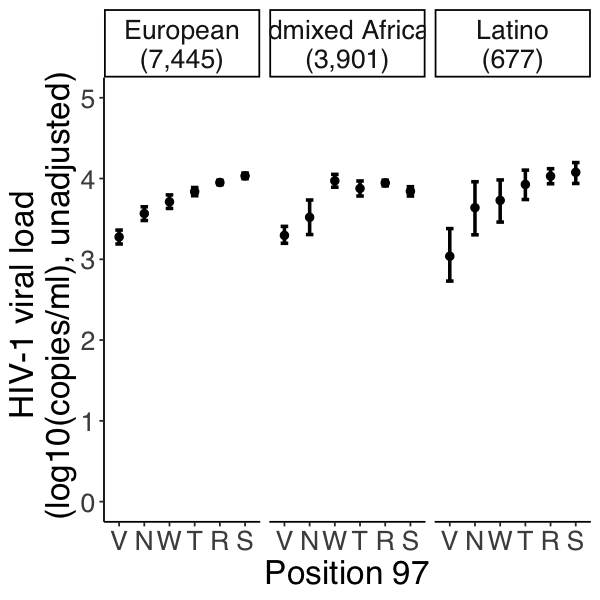

In [30]:
plt.df$pop <- factor(plt.df$pop,levels=c("eur","aa","lat"))
p <- ggplot(plt.df %>% filter(present==1), 
            aes(reorder(res,vl,FUN=median),y=vl)) 

p <- p  + stat_summary(fun.data = mean_cl_boot, geom = "errorbar", aes(width=0.3),colour = "black", size=1) + 
  stat_summary(fun.y = mean, geom = "point", colour = "black",size=2)

# New facet label names for populations
pop.labs <- c("Admixed African\n(3,901)", "European\n(7,445)","Latino\n(677)")

names(pop.labs) <- c("aa", "eur","lat")
p <- p + facet_grid(~pop,labeller = labeller(pop=pop.labs))  + ylim(0,5)

p + theme(axis.text.x = element_text(angle = 0, hjust = 0.5)) + 
  xlab("Position 97") + ylab("HIV-1 viral load \n (log10(copies/ml), unadjusted)")

ggsave("../figs/EDF4_spVL97.pdf",width=180,height=100,units="mm")


## MHC diversity (Extended Data Figure 5)

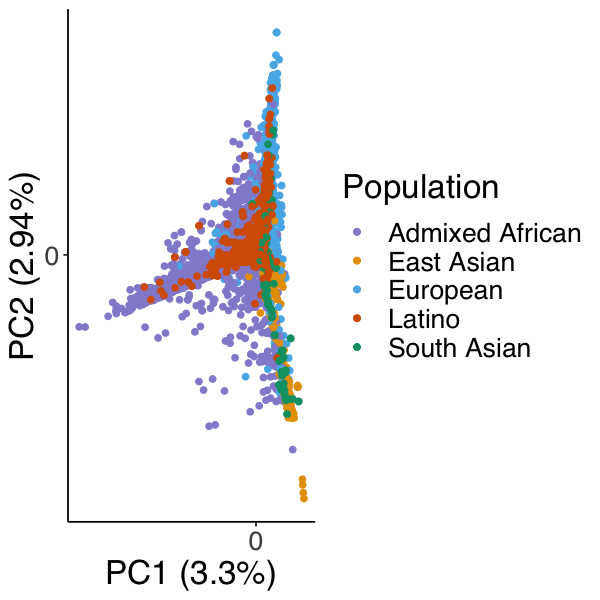

In [44]:
pc <- read.table("../data//all_ibd_pcs.txt.gz",h=T,stringsAsFactors = F)

# for better visualization
pc$label <- "a"
pc[pc$ancestry=="LAT" | pc$ancestry=="SAS",]$label <- "focus" 

varexp <- c(0.033,0.0294)*100

weightedpc.plot <- ggplot(pc,aes(x=V1,y=V2,color=ancestry)) + geom_point() +
    geom_point(data=subset(pc,label == "focus"), aes(x=V1,y = V2, color = ancestry)) 
    #scale_alpha_manual(guide="none",values=list(a=1,focus=.8))


weightedpc.plot <- weightedpc.plot + scale_colour_manual(values=pop_colors,
                                                         name="Population",
                                                        labels=pop_labels)



weightedpc.plot <- weightedpc.plot + 
   xlab(paste("PC1 (",round(varexp[1],2),"%)",sep=""))+ylab(paste("PC2 (",round(varexp[2],2),"%)",sep=""))


# weightedpc.plot  <- weightedpc.plot + theme(legend.position="top",
#                         plot.background=element_blank(),
#                         text = element_text(size = 20, family = "sans"))
 weightedpc.plot  <- weightedpc.plot  + scale_x_continuous(breaks = 0) + scale_y_continuous(breaks = 0)
weightedpc.plot


ggsave(filename = "../figs/EDF5-PCA.pdf",width=180,height=120,units="mm")

## G-group diversity (Extended Data Figure 6)

In [12]:
dat<-read.table("../data/Ggroups.txt.gz",h=T,sep=" ")
dim(dat)
dat[dat$ethnicity == "missing", ]$ethnicity <- "AFR"
# summary of total ancestry 
table(dat$ethnicity)

# Total number of G-group alleles within each ancestry
ddply(dat,~ethnicity,summarise,count=length(unique(c(A1,A2,B1,B2,C1,C2,DQA11,DQA12,DQB11,DQB12,DRB11,DRB12))))
#head(dat)

[1] 21546    22


    AFR     EAS     EUR     LAT missing     SAS 
   7849    2069   10187     952       0     489 

ethnicity,count
<fct>,<int>
AFR,323
EAS,247
EUR,307
LAT,256
SAS,184


In [13]:
#creat frequency table

create_table<-function(dat=JPN2,genes=c("A","B","C","DQA1","DQB1","DRB1", "DPA1","DPB1")){
    out<-NULL
    for (gene in genes){
        x<-subset(dat,select=c(paste(gene,"1",sep="")))
        y<-subset(dat,select=c(paste(gene,"2",sep="")))
        df<-na.omit(cbind(x,y))
        frq<-data.frame(table(as.vector(unlist(df[,1:2]),mode='character'))/(nrow(dat)*2))
        frq$Gene<-gene
        out<-rbind(out,frq)
    }
    return(data.frame(out))
}

In [14]:
all <- NULL
frq <- create_table(dat=dat[dat$ethnicity=="LAT",])
frq$Ethnicity<-"LAT"
all<-rbind(all,frq)

frq<-create_table(dat=dat[dat$ethnicity=="EUR",])
frq$Ethnicity<-"EUR"
all<-rbind(all,frq)

frq<-create_table(dat=dat[dat$ethnicity=="AFR",])
frq$Ethnicity<-"AA"
all<-rbind(all,frq)

frq<-create_table(dat=dat[dat$ethnicity=="EAS",])
frq$Ethnicity<-"EAS"
all<-rbind(all,frq)

frq<-create_table(dat=dat[dat$ethnicity=="SAS",])
frq$Ethnicity<-"SAS"
all<-rbind(all,frq)

#head(all)
#define top most frequent alleles
df2<-all %>% group_by(Gene,Ethnicity) %>% top_n(2, Freq) %>% arrange(Gene,Ethnicity,desc(Freq))
others<-setDT(all[all$Var1 %in% df2$Var1,])[, .(Var1="others",Freq=1-sum(Freq)), by= .(Gene, Ethnicity)] 

df3<-rbind(all[all$Var1 %in% df2$Var1,],others)
count<-aggregate(df3$Var1, list(df3$Gene),unique)


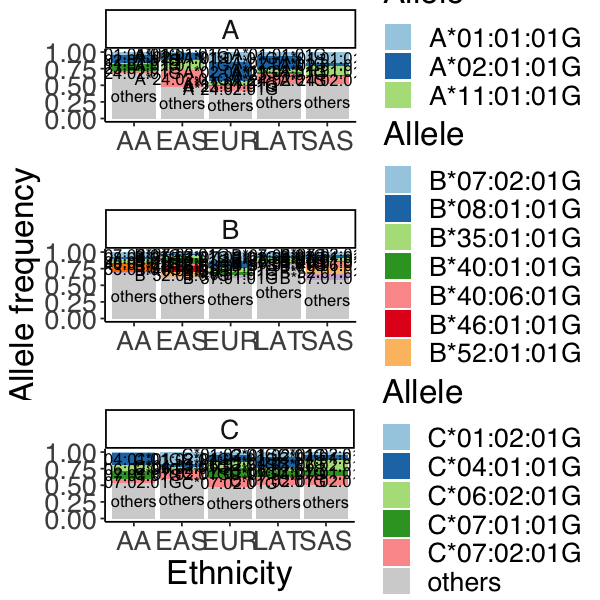

In [17]:
ncolor<-unlist(lapply(count[,2],function(xx){length(as.vector(unlist(xx)))}))

# Classic palette Set1
cbPalette=unlist(lapply(ncolor-1,brewer.pal,"Paired"))

Ggroup <- split(df3, f = df3$Gene)

Ggroup$A$Label <- ifelse(Ggroup$A$Freq > 1e-2,as.character(Ggroup$A$Var1),"")

p1 <- ggplot(Ggroup$A,aes(x=Ethnicity,y=Freq,fill=Var1))+geom_bar(stat='identity')+
    facet_wrap(~Gene) + 
    geom_text(aes(label=Label), position=position_stack(vjust = 0.5), size = 3.5) + 
    scale_fill_manual(name="Allele",values=c(cbPalette[1:5],"lightgrey")) + 
    ylab("")+ xlab("")


Ggroup$B$Label <- ifelse(Ggroup$B$Freq > 1e-2,as.character(Ggroup$B$Var1),"")
p2 <- ggplot(Ggroup$B,aes(x=Ethnicity,y=Freq,fill=Var1))+geom_bar(stat='identity')+
    facet_wrap(~Gene) + 
    geom_text(aes(label=Label), position=position_stack(vjust = 0.5), size = 3.5) + 
    scale_fill_manual(name="Allele",values=c(cbPalette[6:14],"lightgrey"))+
     ylab("Allele frequency") + xlab("")

Ggroup$C$Label <- ifelse(Ggroup$C$Freq > 1e-2,as.character(Ggroup$C$Var1),"")
p3 <- ggplot(Ggroup$C,aes(x=Ethnicity,y=Freq,fill=Var1))+geom_bar(stat='identity')+
    facet_wrap(~Gene) + 
    geom_text(aes(label=Label), position=position_stack(vjust = 0.5), size = 3.5) + 
    scale_fill_manual(name="Allele",values=c(cbPalette[15:19],"lightgrey"))+ ylab("")

p <- grid.arrange(p1, p2,p3 ,ncol=1)
ggsave(p,filename = "../figs/EDF6_G-group_classI_freq.pdf",width=12,height=16)

#ggsave(p,filename = "../figs/EDF6_G-group_classI_freq.pdf",width=180,height=120,units="mm")

TableGrob (5 x 1) "arrange": 5 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]
3 3 (3-3,1-1) arrange gtable[layout]
4 4 (4-4,1-1) arrange gtable[layout]
5 5 (5-5,1-1) arrange gtable[layout]

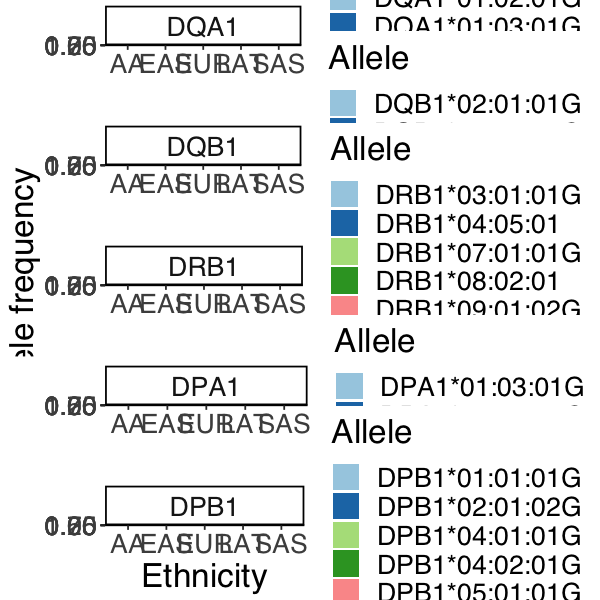

In [18]:
##  Class II
Ggroup <- split(df3, f = df3$Gene)

Ggroup$DQA1$Var1 <- ifelse(Ggroup$DQA1$Var1=="DQA1*02:01","DQA1*02:01:01G",as.character(Ggroup$DQA1$Var1))
Ggroup$DQA1$Label <- ifelse(Ggroup$DQA1$Freq > 1e-2,as.character(Ggroup$DQA1$Var1),"")
p1 <- ggplot(Ggroup$DQA1,aes(x=Ethnicity,y=Freq,fill=Var1))+geom_bar(stat='identity')+
    facet_wrap(~Gene) + 
    geom_text(aes(label=Label), position=position_stack(vjust = 0.5), size = 3.5) + 
    scale_fill_manual(name="Allele",values=c(cbPalette[1:5],"lightgrey")) + 
    ylab("")+ xlab("")


Ggroup$DQB1$Label <- ifelse(Ggroup$DQB1$Freq > 1e-2,as.character(Ggroup$DQB1$Var1),"")
p2 <- ggplot(Ggroup$DQB1,aes(x=Ethnicity,y=Freq,fill=Var1))+geom_bar(stat='identity')+
    facet_wrap(~Gene) + 
    geom_text(aes(label=Label), position=position_stack(vjust = 0.5), size = 3.5) + 
    scale_fill_manual(name="Allele",values=c(cbPalette[6:11],"lightgrey"))+
     ylab("") + xlab("")

Ggroup$DRB1$Label <- ifelse(Ggroup$DRB1$Freq > 1e-2,as.character(Ggroup$DRB1$Var1),"")
p3 <- ggplot(Ggroup$DRB1,aes(x=Ethnicity,y=Freq,fill=Var1))+geom_bar(stat='identity')+
    facet_wrap(~Gene) + xlab("")+
    geom_text(aes(label=Label), position=position_stack(vjust = 0.5), size = 3.5) + 
    scale_fill_manual(name="Allele",values=c(cbPalette[6:13],"lightgrey"))+ ylab("Allele frequency")

Ggroup$DPA1$Label <- ifelse(Ggroup$DPA1$Freq > 1e-2,as.character(Ggroup$DPA1$Var1),"")
p4 <- ggplot(Ggroup$DPA1,aes(x=Ethnicity,y=Freq,fill=Var1))+geom_bar(stat='identity')+
    facet_wrap(~Gene) + 
    geom_text(aes(label=Label), position=position_stack(vjust = 0.5), size = 3.5) + 
    scale_fill_manual(name="Allele",values=c(cbPalette[1:3],"lightgrey"))+ ylab("") + xlab("")
Ggroup$DPB1$Label <- ifelse(Ggroup$DPB1$Freq > 1e-2,as.character(Ggroup$DPB1$Var1),"")
p5 <- ggplot(Ggroup$DPB1,aes(x=Ethnicity,y=Freq,fill=Var1))+geom_bar(stat='identity')+
    facet_wrap(~Gene) + 
    geom_text(aes(label=Label), position=position_stack(vjust = 0.5), size = 3.5) + 
    scale_fill_manual(name="Allele",values=c(cbPalette[1:5],"lightgrey"))+ ylab("")

    
p <- grid.arrange(p1, p2,p3,p4 ,p5,ncol=1)
p
ggsave(p,filename = "../figs/EDF6_G-group_classII_freq.pdf",width=12,height=16)


## Overall G-group diversity in eight HLA genes (Extended Data Figure 7)

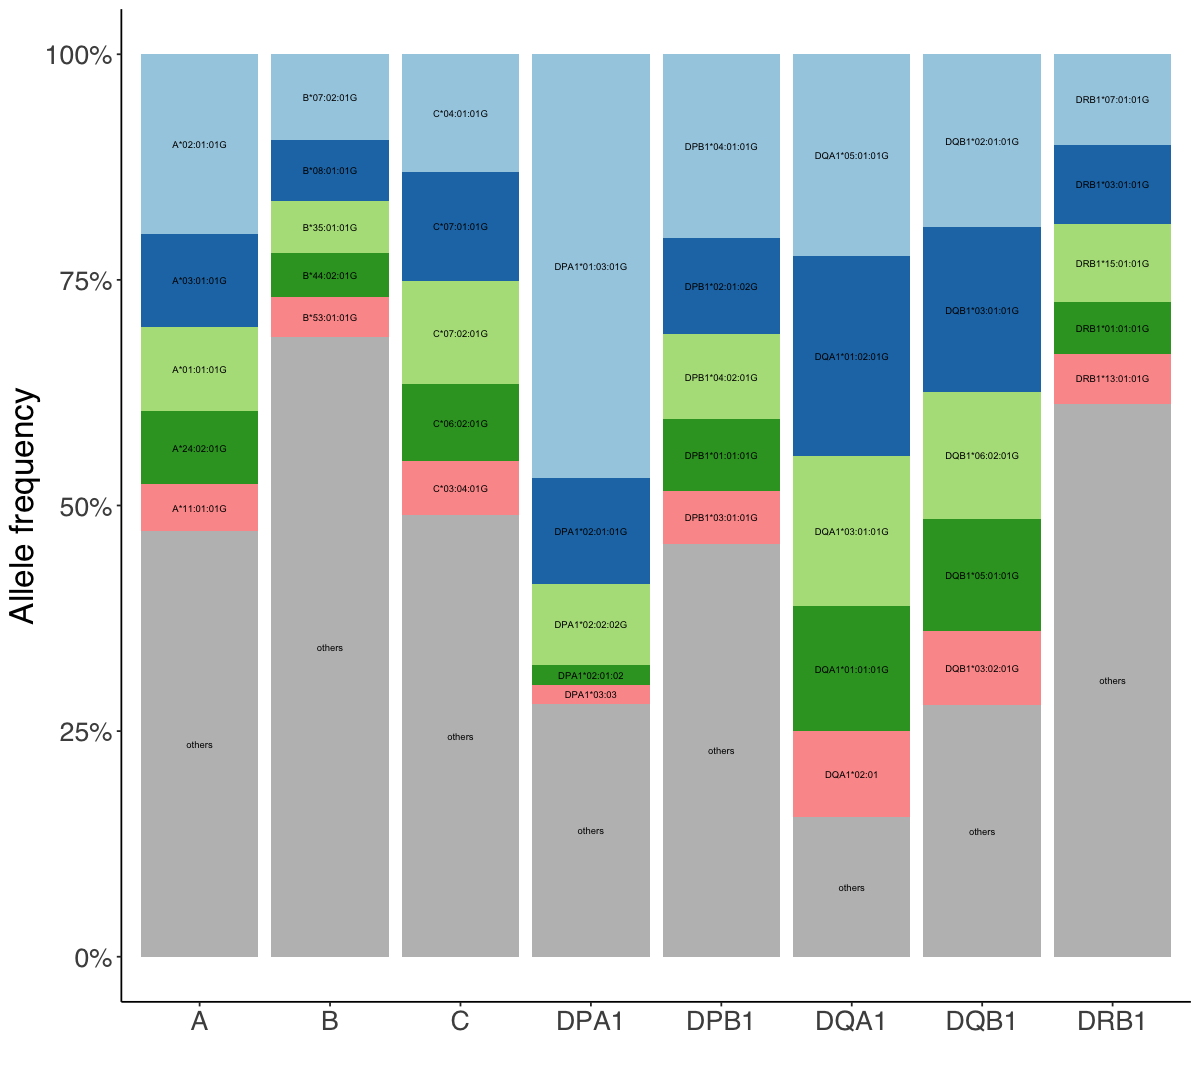

In [59]:
Ggroup<-read.table("../data/Ggroups.txt.gz",h=T,sep=" ")
Ggroup[Ggroup$ethnicity == "missing", ]$ethnicity <- "AFR"
Ggroup$ethnicity <- factor(Ggroup$ethnicity)

all <- create_table(dat=Ggroup[!is.na(Ggroup$ethnicity),])

#define top most frequent alleles
n <- 5
df2 <- all %>% group_by(Gene) %>% top_n(n, Freq) %>% arrange(Gene,desc(Freq))
others <- setDT(all[all$Var1 %in% df2$Var1,])[, .(Var1="others",Freq=1-sum(Freq)), by= .(Gene)] %>% arrange(Gene,desc(Freq))
others$order <- n+1

df3 <- df2 %>% group_by(Gene) %>% arrange(Gene,desc(Freq))
df3$order <- rep(c(1:n),8)

df4 <- rbind(data.frame(df3),as.data.frame(others))


freq.plt <- ggplot(df4,aes(x=Gene,y=Freq,fill=as.factor(order)))+geom_bar(stat='identity')+scale_y_continuous(label=percent)+
    geom_text(aes(label=Var1), position=position_stack(vjust = 0.5), size=2)
freq.plt <- freq.plt + theme(legend.position = "none" ) + scale_fill_manual(values=c(brewer.pal(5,"Paired"),"grey"))

options(repr.plot.width = 10, repr.plot.height = 9)


freq.plt <- freq.plt + xlab("") + ylab("Allele frequency")

freq.plt  <- freq.plt +  theme(legend.position="none",
                        plot.background=element_blank(),
                        text = element_text(family = "sans"))
freq.plt

ggsave(filename = "../figs/EDF7-freq.pdf",width=180,height=150,units="mm")


### epsilon (Extended Data Figure 8)

In [20]:
M <- 0
for (pop in c("EUR","SAS","EAS","LAT","AA")){
  M1 <- as.matrix(read.table(paste("../data/",pop,"_eps.txt",sep=""),h=T,stringsAsFactors = F))
  M <- M + M1
}

#M/5
rownames(M)<-colnames(M)<-c("A","C","B","DRB1","DQA1","DQB1","DPA1","DPB1")


cols <- colorRampPalette(rev(pal_locuszoom(palette = c("default"))(4)))

pdf("../figs/EDF8_all_eps.pdf",height=7,width=7)  
#diag(M) = 1
corrplot.mixed(M/5, lower.col=cols(50),upper = "circle", 
                 tl.col = "black", upper.col = cols(50), cl.lim=c(0,.35),tl.cex=1.3)

dev.off()


pdf 
  2

## MHC selection (Extended Data Figure 9)

In [62]:
admix = read.table("../data/g1k-mesa-prunedALL.4.Q")
fam = read.table("../data/g1k-mesa-prunedALL.fam")
g1k_label =read.table("../data/integrated_call_samples_v3.20130502.ALL.panel",header=T,stringsAsFactors = F)
fam$superpop = g1k_label[match(fam$V1, g1k_label$sample),"super_pop"]

# load inferred MESA info
MESA_AA.sample = read.table("../data/MESA_AA_samples.txt",stringsAsFactors = F)
MESA_AMR.sample = read.table("../data/MESA_Latino_samples.txt", stringsAsFactors = F)

fam$superpop[fam$V1 %in% MESA_AA.sample$V1] ="MESA_AA"
fam$superpop[fam$V1 %in% MESA_AMR.sample$V1] ="MESA_AMR"


In [63]:
# For Admixed Africans (AA), column 2 is EUR, column 1 is NAT, column 3 is AFR 
MESA_AA_AFR_global_mean = 2*mean(admix[fam$superpop=="MESA_AA",3],na.rm = TRUE)
MESA_AA_AFR_global_sd = 2*sd(admix[fam$superpop=="MESA_AA",3],na.rm = TRUE) 
MESA_AA_EUR_global_mean = 2*mean(admix[fam$superpop=="MESA_AA",2],na.rm = TRUE)
MESA_AA_EUR_global_sd = 2*sd(admix[fam$superpop=="MESA_AA",2],na.rm = TRUE)



In [64]:
# For Latinos (AMR), column 2 is EUR, column 1 is NAT, column 3 is AFR 
MESA_AMR_AFR_global_mean = 2*mean(admix[fam$superpop=="MESA_AMR",3],na.rm = TRUE)
MESA_AMR_AFR_global_sd = 2*sd(admix[fam$superpop=="MESA_AMR",3],na.rm = TRUE) 
MESA_AMR_EUR_global_mean = 2*mean(admix[fam$superpop=="MESA_AMR",2],na.rm = TRUE)
MESA_AMR_EUR_global_sd = 2*sd(admix[fam$superpop=="MESA_AMR",2],na.rm = TRUE)


### selection in AA (EXDF9a)

In [65]:
##rfmix AA 
AA_dose= read.table("../data/MESA_AA_subset_rfmix.dose.gz",h=T)
colnames(AA_dose)=c("chromosome","physical_position","genetic_position","genetic_marker_index","AFR","EUR")
AA_dose_mean =mean(AA_dose$AFR)
AA_dose_sd = sd(AA_dose$AFR)

In [66]:
#elai AA
AA_elai =read.table("../data/MESA_AA_new_0402.ps21.txt.gz")
AA_snp = read.table("../data/MESA_AA_new_0402.snpinfo.txt",header=T)
AA_elai_AFR = colMeans(AA_elai[, seq(2,127946,2)])
AA_elai_mean = mean(AA_elai_AFR)

In [67]:
rfmix.plt <- AA_dose
rfmix.plt$average <- scale(AA_dose$AFR) + AA_dose_mean - MESA_AA_AFR_global_mean

rfmix.plt %>%  filter(physical_position>=28*1e6 & physical_position <= 34*1e6) %>% 
  select(average) %>% colMeans()

elai.plt <- cbind(AA_snp,average=scale(AA_elai_AFR)+ AA_elai_mean - MESA_AA_AFR_global_mean)
elai.plt %>%  filter(pos>=28*1e6 & pos <= 34*1e6) %>% 
  select(average) %>% summarise(mean.average = mean(average,na.rm=T),
                                sd.average = sd(average,na.rm=T),
                                n.average = n()) %>%
              mutate(se.average = sd.average / sqrt(n.average),
                     lower.ci.average = mean.average - qt(1-(0.05/2),n.average -1)* se.average,
                     uppper.ci.average = mean.average + qt(1-(0.05/2),n.average -1)* se.average)


average 
1.560842

mean.average,sd.average,n.average,se.average,lower.ci.average,uppper.ci.average
<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
3.419453,1.209388,1141,0.03580328,3.349206,3.489701


In [68]:
# outside MHC
df<- cbind(AA_snp,AA_elai_AFR)
x <- df %>%  filter(pos<28*1e6 |pos > 34*1e6) %>% 
  select(AA_elai_AFR) 
mean(as.vector(unlist(x)))/2

# inside MHC
x <- df %>%  filter(pos>=28*1e6 &pos <= 34*1e6) %>% 
  select(AA_elai_AFR) 
mean(as.vector(unlist(x)))/2

[1] 0.7449104

[1] 0.7802313

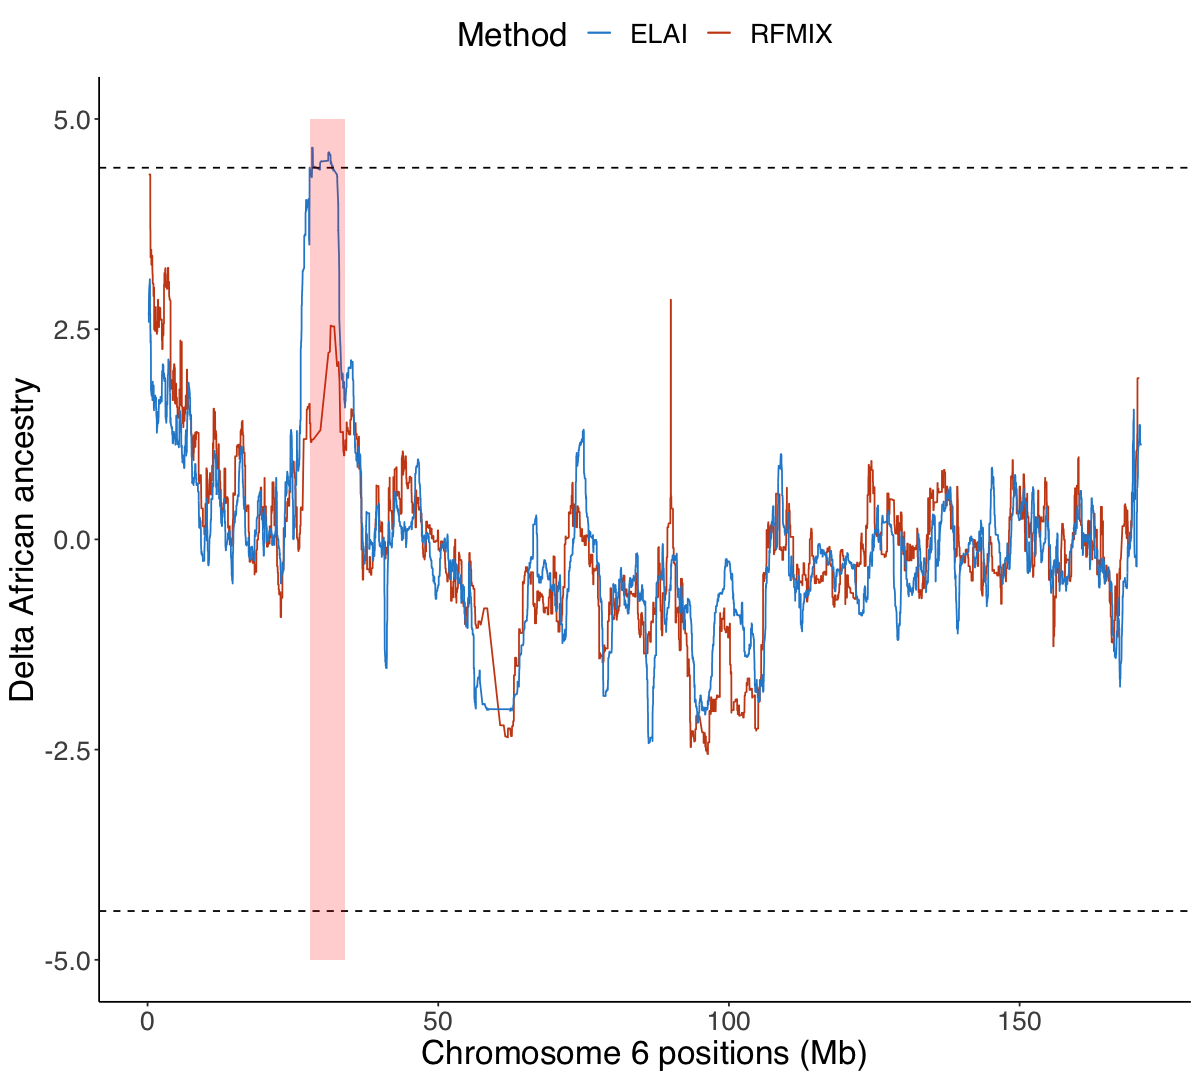

In [70]:
AAplt <- ggplot()+ geom_line(data=rfmix.plt, aes(x=physical_position/1e6, y=scale(average), color="rfmix" ))+
  geom_line(data= AA_snp, aes(x=pos[pos>1e5]/1e6, y=scale(AA_elai_AFR)+ AA_elai_mean - MESA_AA_AFR_global_mean, color="ELAI"))+
  geom_hline(yintercept = 4.42 , color="black", linetype="dashed")+
  geom_hline(yintercept = - 4.42 , color="black", linetype="dashed")+
#  geom_hline(yintercept = 0 , color="black", linetype="dashed")+
  annotate("rect", xmin=28000000/1e6, xmax=34000000/1e6, ymin=-5, ymax=5, alpha=0.2, fill="red") +
  ylab("Delta African ancestry")  + xlab("Chromosome 6 positions (Mb)")+
  scale_color_manual(name="Method",labels=c("ELAI","RFMIX"),values=c("#268bd2", "#cb4b16"))+
  theme(legend.position = "top")
AAplt
ggsave("../figs/EDF9a_MESA-AA-selection.pdf", height = 100, width = 180,units="mm")

### selection in Latios (EDF9b)

In [71]:
##rfmix AMR
AMR_dose= read.table("../data/MESA_AMR_subset_rfmix.dose.gz",header=T)
AMR_dose_mean =mean(AMR_dose$AFR)
AMR_dose_sd = sd(AMR_dose$AFR)

## elai AMR
AMR_elai =read.table("../data/MESA_Latinos_3way_0402.ps21.txt.gz")
AMR_snp = read.table("../data/MESA_Latinos_3way_0402.snpinfo.txt",header=T)
AMR_elai_AFR = colMeans(AMR_elai[, seq(2,191994,3)])
AMR_elai_mean = mean(AMR_elai_AFR)
AMR_elai_sd = sd(AMR_elai_AFR)

In [72]:
elai.AMR.plt <- cbind(AMR_snp,average=scale(AMR_elai_AFR)+ AMR_elai_mean - MESA_AMR_AFR_global_mean)

elai.AMR.plt %>%  filter(pos>=28*1e6 & pos <= 34*1e6) %>% 
  select(average) %>% summarise(mean.average = mean(average,na.rm=T),
                                sd.average = sd(average,na.rm=T),
                                n.average = n()) %>%
  mutate(se.average = sd.average / sqrt(n.average),
         lower.ci.average = mean.average - qt(1-(0.05/2),n.average -1)* se.average,
         uppper.ci.average = mean.average + qt(1-(0.05/2),n.average -1)* se.average)


# outside MHC
df<- cbind(AMR_snp,AMR_elai_AFR)
x <- df %>%  filter(pos<28*1e6 |pos > 34*1e6) %>% 
  select(AMR_elai_AFR) 
mean(as.vector(unlist(x)))/2

# inside MHC
x <- df %>%  filter(pos>=28*1e6 &pos <= 34*1e6) %>% 
  select(AMR_elai_AFR) 
mean(as.vector(unlist(x)))/2




mean.average,sd.average,n.average,se.average,lower.ci.average,uppper.ci.average
<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
4.232002,1.456116,1149,0.0429572,4.147719,4.316285


[1] 0.05761976

[1] 0.1598449

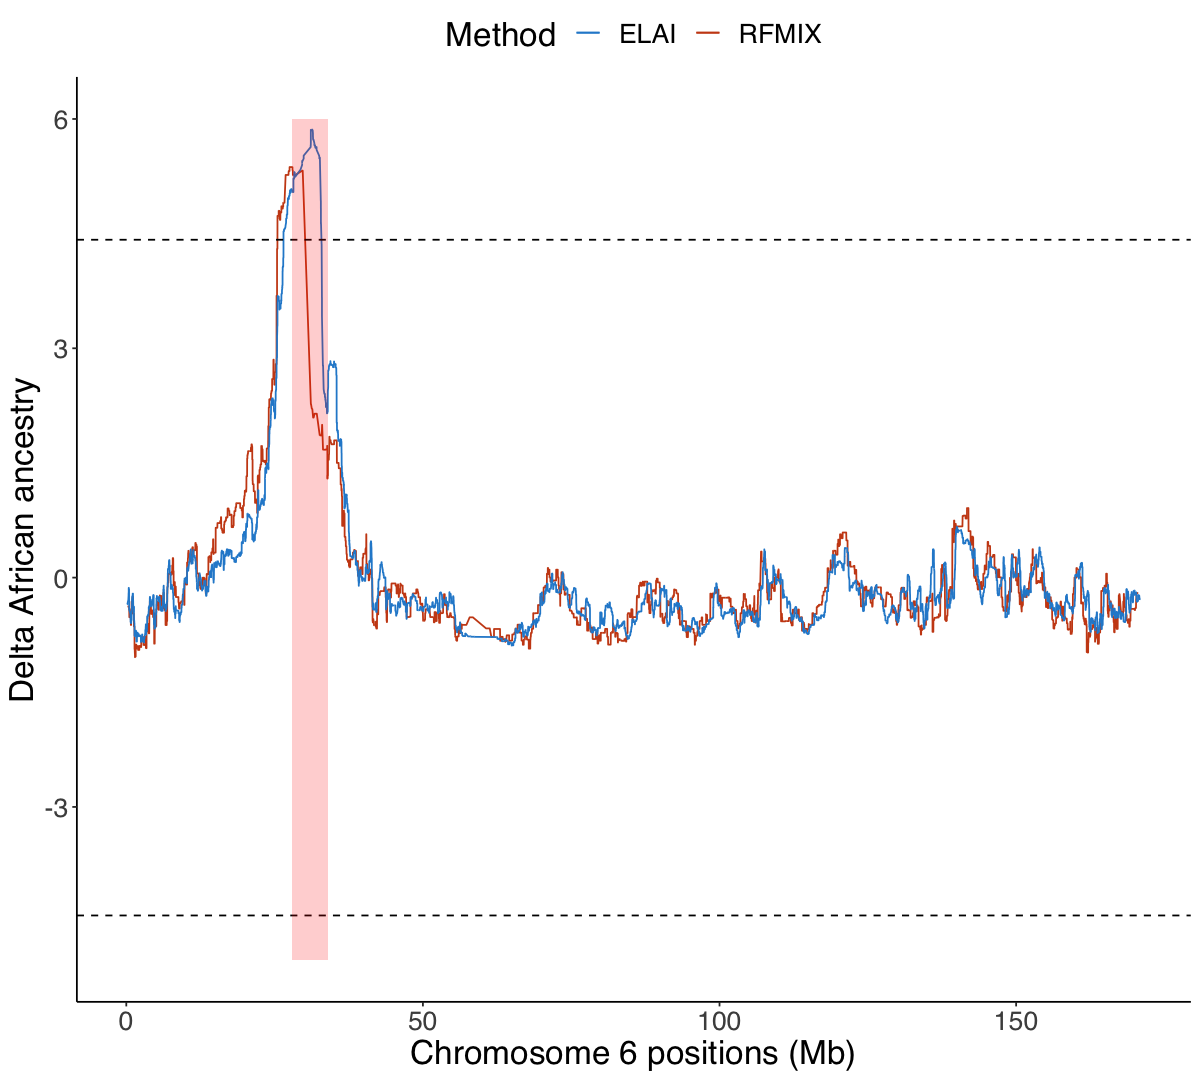

In [73]:
LATplt <- ggplot()+ geom_line(data=AMR_dose, aes(x=physical_position/1e6,scale(AFR), color="rfmix" ))+
  geom_line(data= AMR_snp, aes(x=pos[pos>1e5]/1e6, y=scale(AMR_elai_AFR), color="ELAI"))+
  geom_hline(yintercept = 4.42 , color="black", linetype="dashed")+
  geom_hline(yintercept = - 4.42 , color="black", linetype="dashed")+
  #  geom_hline(yintercept = 0 , color="black", linetype="dashed")+
  annotate("rect", xmin=28000000/1e6, xmax=34000000/1e6, ymin=-5, ymax=6, alpha=0.2, fill="red") +
  ylab("Delta African ancestry") + xlab("Chromosome 6 positions (Mb)")+
  scale_color_manual(name="Method",labels=c("ELAI","RFMIX"),values=c("#268bd2", "#cb4b16")) + 
  theme(legend.position = "top")
LATplt
ggsave("../figs/EDF9b_MESA-LAT-selection.pdf", height = 100, width = 180,units="mm")

Warning message:
“Graphs cannot be horizontally aligned unless the axis parameter is set. Placing graphs unaligned.”


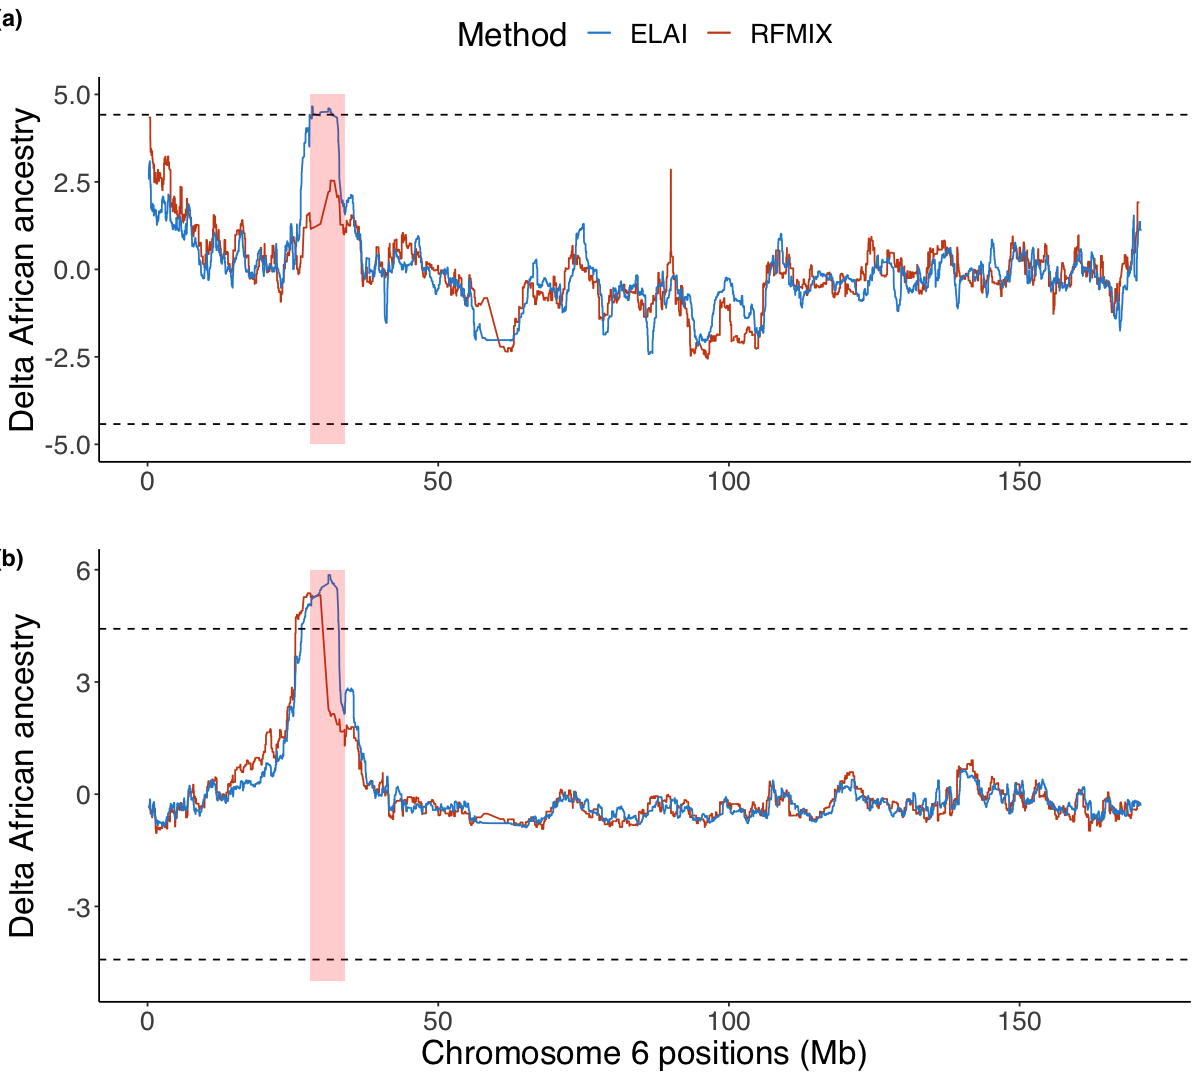

In [77]:
# combine two plots

prow <- plot_grid( AAplt + xlab(""),
           LATplt + theme(legend.position="none"),
           align = 'vh',
           labels = c("(a)", "(b)"),
           hjust = .2,
           nrow = 2
           )

#add to plot

prow
ggsave("../figs/EDF9_MESA_selection.pdf", height = 200, width = 180,units="mm")
#grid.arrange(arrangeGrob(prow, left = y.grob))



## conditional analysis of previous signals (Extended Data Figure 10)

In [7]:
aa.manhattan <- function(df = assoc, showxlab = TRUE,  showylab = FALSE, hlight=c("B-97"),
                         nudge_value = -20,eurhlight=eur_aa,aahlight=afr_aa){
    df.assoc <- NULL
    genes <- c("A","C","B","DRB1","DQA1","DQB1","DPA1","DPB1")
    for (gene in genes){
        assoc <- df %>% filter(grepl("AA_",AA_ID)) %>% na.omit() %>% 
            select(GENE,AA_POS,POS,PVALUE, SNP) %>%  group_by(GENE) %>% arrange(AA_POS)
        df1 <- assoc
        df.tmp <- df1[df1$GENE==gene, ]
        df.tmp$BP <- abs(df.tmp$AA_POS - df.tmp$AA_POS[1] )
        df.assoc <- rbind(df.assoc, df.tmp)
    }

    df.tmp <- df.assoc %>% 
        # compute gene length
        group_by(GENE) %>% mutate(rowID = 1:n()) 

    df.assoc <- df.tmp %>% summarise(gene_len=length(BP) ) %>% arrange(genes) %>%
        # calcuate cumulative positoin of each gene
            mutate(tot = cumsum(gene_len) - gene_len + 50) %>%

        # add info
        left_join(df.tmp,., by=c("GENE"="GENE")) %>%

        # Add a cumulate position of each amino acid
        arrange(GENE,rowID) %>% mutate(BPcum = tot + rowID) %>%
    
        # Add highlight and annotation information
        mutate( is_highlight=ifelse(SNP %in% hlight, "yes", "no")) %>%
        mutate( is_annotate=ifelse(SNP %in% hlight, "yes", "no")) %>%
    
        # Add highlight and annotation information European
      mutate( is_highlight_eur=ifelse(SNP %in% eurhlight, "yes", "no")) %>%
      mutate( is_annotate_eur=ifelse(SNP %in% eurhlight, "yes", "no")) %>%
    
        # Add highlight and annotation information from African American reported value
        mutate( is_highlight_aa=ifelse(SNP %in% aahlight, "yes", "no")) %>%
        mutate( is_annotate_aa=ifelse(SNP %in% aahlight, "yes", "no"))
  
    
    axisdf <- df.assoc %>% group_by(GENE) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 ) %>% arrange(genes)

    p <- ggplot(df.assoc, aes(x = BPcum, y = -log10(PVALUE), size = -log10(PVALUE))) + 
    geom_point( shape = 23)
    
    ymax <- max(-log10(df.assoc$PVALUE))*1.5
    p <- p + scale_fill_manual( values = gene_colors) + 
        scale_x_continuous( label = genes, breaks= axisdf$center ) +
        labs(x = "Amino acid positions") + 
        scale_y_continuous(limits=c(0,ymax), breaks = scales::pretty_breaks(n=4))

    # Add highlighted points
    p <- p + geom_point(data=subset(df.assoc, is_highlight=="yes"), fill="darkred",size =5, pch=23) 

    p <- p + geom_point(data=subset(df.assoc, is_highlight_aa=="yes"), fill=pop_colors[1],size =5, pch=23) +
     geom_point(data=subset(df.assoc, is_highlight_eur=="yes"), fill=pop_colors[2], size = 5, pch=23) 
    p <- p + 
        # Add label using ggrepel to avoid overlapping
        geom_text_repel(data=df.assoc[df.assoc$is_annotate=="yes",], 
                     aes(label=as.factor(SNP)), size=6,
                        nudge_x = -nudge_value, segment.size = 0.2, show.legend = FALSE) 
    
    p <- p + 
    geom_text_repel(data=df.assoc[df.assoc$is_annotate_aa=="yes",], 
                     aes(label=as.factor(SNP)), size=6,
                        nudge_x = nudge_value, segment.size = 0.2, show.legend = FALSE) +
    
    geom_text_repel(data=df.assoc[df.assoc$is_annotate_eur=="yes",], 
                     aes(label=as.factor(SNP)), size=6,
                        nudge_x = - nudge_value, segment.size = 0.2, show.legend = FALSE) 
    
    # add genome-wide threshold
    p <- p + geom_hline(yintercept = -log10(5e-8),linetype="dashed", color="black")
    # whether needs the xlabs
    if(showxlab == TRUE){
        p <- p + theme(legend.position = "none",axis.text.x = element_text(angle = 90)) 
    }else{
        p<- p + theme(legend.position = "none",axis.title.x = element_blank(), axis.text.x = element_blank())

    }
    if(showylab == TRUE){
        p <- p + theme(legend.position = "none") + ylab("-log10(P)")
    }else{
        p <- p + theme(legend.position = "none",axis.title.y = element_blank()) 

    }
}

In [8]:
# previously reported amino acid positions
eur_aa <- c("B-97", "B-67", "A-77", "B-45", "A-95")
afr_aa <- c("B-97"  ,"B-245", "B-116", "B-63" )



AA_ID,GENE,AA_POS,POS,DOF,SS,PVALUE,PVALUE_HET,AA,N_AA,N_HAPLO,N_HAPLO_ADD,PctExp,SNP
<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<dbl>,<chr>


`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



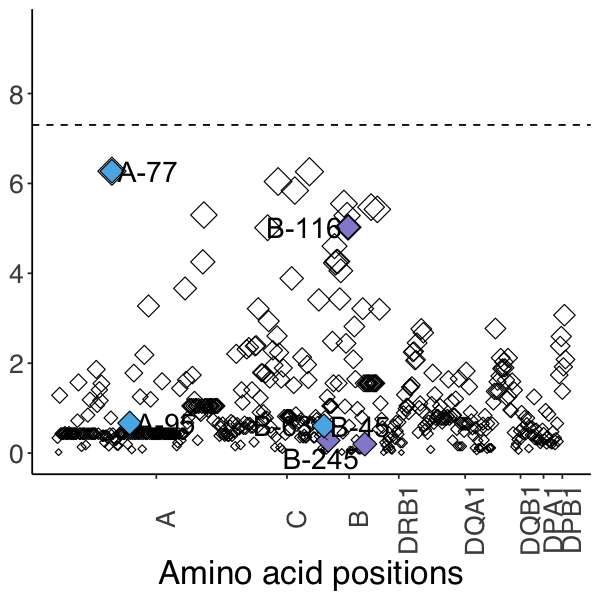

In [9]:
pop_colors <- c("#938dd2","#56B4E9","#D55E00")
pop_labels <- c("Admixed African","European","Latino")
# condition on four amino acid positions identified in this study (B97, B67, B156, A77)
df <- read.table("../data/all.4th.txt",h=T,stringsAsFactors = F)
assoc <- df[ df$AA_POS>0,]
assoc$SNP <- paste(assoc$GENE,assoc$AA_POS,sep="-")
x <- na.omit(assoc)
x[x$PVALUE<5e-8,] %>% filter(grepl("AA_",AA_ID))

p.current <- aa.manhattan(df = assoc,eurhlight=eur_aa,aahlight=afr_aa,showylab=FALSE)

p.current


`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



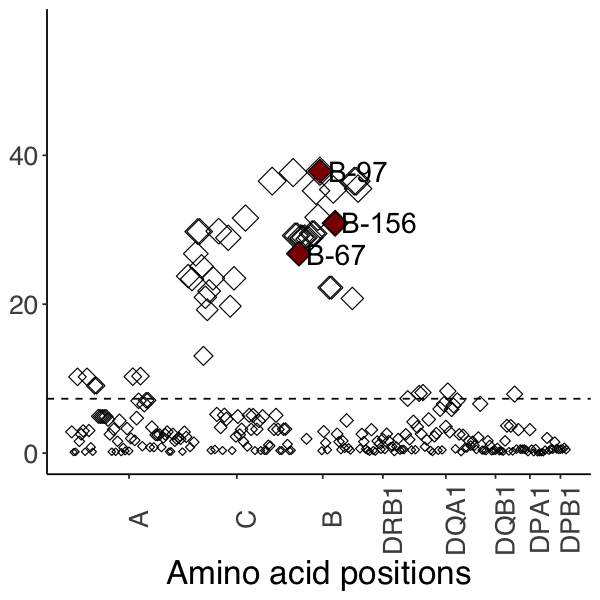

In [10]:
# condition on four amino acid positions identified in other sutides only (B45, B63, B116, A95)
current_aa <- c("B-97"  ,"B-156", "B-67" )

df <- read.table("../data/all.previous.txt",h=T,stringsAsFactors = F)
assoc <- df[ df$AA_POS>0,]
assoc$SNP <- paste(assoc$GENE,assoc$AA_POS,sep="-")
x <- na.omit(assoc)

p.previous <- aa.manhattan(df = assoc,hlight=current_aa,aahlight=NULL,eurhlight=NULL,showylab=FALSE)

p.previous


In [11]:
# combine two plots

prow <- plot_grid( p.current + theme(legend.position="none"),
           p.previous + theme(legend.position="none"),
           align = 'vh',
           labels = c("(a)", "(b)"),
           hjust = .2,
           nrow = 1
           )
y.grob <- textGrob(expression(-log10(P[omnibus])), 
                   gp=gpar(fontface="bold", col="black", fontsize=20), rot=90, vjust = .3)

#add to plot

pdf("../figs/EDF10_hiv_conditional_previous_aas.pdf",height=7,width=12)
#png("../figs/EDF10_hiv_conditional_previous_aas.png", height = 7, width = 12, units= "in", res=200)
    
grid.arrange(arrangeGrob(prow, left = y.grob))

dev.off()

pdf 
  2